## Import libraries

In [ ]:
# !pip install optuna
# !pip install catboost
# !pip install shap
# !pip install hrv-analysis
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from tqdm import tqdm_notebook
import warnings
# import optuna
from sklearn.metrics import accuracy_score, roc_auc_score, make_scorer, auc, roc_curve
# from catboost import CatBoostClassifier, Pool
# import shap
from sklearn.metrics import f1_score
# from hrvanalysis import remove_outliers, remove_ectopic_beats, interpolate_nan_values
warnings.filterwarnings("ignore")
%matplotlib inline

- `train.csv` обучающая выборка со следующими столбцами:  
   - **id** - идентификатор временного ряда сердечного ритма
   - **time** - время в ms ( миллисекунды)
   - **x** - R-R интервал
   - **y** - признак разметки ковидной аномалии

In [ ]:
df = pd.read_csv('train.csv')

In [ ]:
df.rename(columns={"id":"id_user"}, inplace=True)

In [ ]:
df_stats = df.groupby('id_user').x.median().to_frame('val_median')
df_stats['val_mean'] = df.groupby('id_user').x.mean()
df_stats['val_std'] = df.groupby('id_user').x.std()
df_stats.index = df.groupby('id_user').x.median().index
df_stats.reset_index(inplace=True)
df_stats

,id_user,val_median,val_mean,val_std
0,1,748,747.627807,118.458362
1,2,780,777.946903,52.730230
2,3,788,787.695238,26.985439
3,4,788,787.229630,22.042002
4,5,784,784.931217,19.608415
...,...,...,...,...
224,270,620,625.590361,61.842231
225,271,616,637.361702,114.622192
226,272,592,588.991150,24.404513
227,273,616,626.461538,82.063310


In [ ]:
df_new = df.merge(df_stats, on='id_user', how='left')
df_new['x_norm'] = (df_new['x'] / df_new['val_median']).astype('float64')
quantile_list = df_new.x_norm.quantile([i/10 for i in range(10)])
code_list = list('ABCDEFGHIJKLMNOPQRST')[:len(quantile_list)+2]
quantile_list.index = quantile_list.index * 10

In [ ]:
code_list

['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L']

In [ ]:
df_new['x_code'] = np.zeros(df_new.shape[0])
df_new.x_code = ''
q_val_t0 = (quantile_list[0])
df_new.loc[df_new.x_norm < q_val_t0, 'x_code'] = code_list[0]
for i in range(1, len(quantile_list)):
    q_val = quantile_list[i]
    df_new.loc[(df_new.x_norm >= q_val_t0) & (df_new.x_norm < q_val), 'x_code'] = code_list[i]
    q_val_t0 = q_val
q_val_t0 = (quantile_list[9])
df_new.loc[df_new.x_norm >= q_val_t0, 'x_code'] = code_list[11]

In [ ]:
index_ids = df_new.id_user.unique()
count_trshd = 80
seq = ''
sequences = list()
seq_user_id = list()
for iid in index_ids:
    df_id = df_new[df_new.id_user == iid]
    # print(df_id.shape)
    for symbl in df_id.x_code.values:
        seq += symbl
        if len(seq) == count_trshd:
            sequences.append(seq)
            seq_user_id.append(iid)
            seq = ''
    # sequences.append(seq)
    # seq_user_id.append(iid)
    seq = ''
df_rnn = pd.DataFrame({'ID_USER':seq_user_id, 'SEQ': sequences})

In [ ]:
# dict <index>:<char>
# Your great code here

# dict <char>:<index>
# Your great code here
tokens = code_list
print(tokens)
token_to_idx = {token: ind for ind, token in enumerate(tokens)}
idx_to_token = {ind: token for ind, token in enumerate(tokens)}
num_tokens = len(tokens)

print(token_to_idx)
print(idx_to_token)

['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L']
{'A': 0, 'B': 1, 'C': 2, 'D': 3, 'E': 4, 'F': 5, 'G': 6, 'H': 7, 'I': 8, 'J': 9, 'K': 10, 'L': 11}
{0: 'A', 1: 'B', 2: 'C', 3: 'D', 4: 'E', 5: 'F', 6: 'G', 7: 'H', 8: 'I', 9: 'J', 10: 'K', 11: 'L'}


In [ ]:
# Your code here

import torch, torch.nn as nn
import time
from torch.optim import lr_scheduler, Adam
import torch.nn.functional as F
import numpy as np
from IPython.display import clear_output
from random import sample
from torch.utils.data import DataLoader
from matplotlib import pyplot as plt
import torch, torch.nn as nn
import torch.nn.functional as F

from IPython.display import clear_output
from random import sample

device = "cuda:0" if torch.cuda.is_available() else "cpu"
print(device)

# Your beautiful code here
class LSTM(nn.Module):
    
    def __init__(self, num_tokens=len(token_to_idx), embedding_size=16, rnn_num_units=256):
        super(self.__class__, self).__init__()
        self.num_units = rnn_num_units
        self.embedding = nn.Embedding(num_tokens, embedding_size)
        
        self.lstm = nn.LSTMCell(embedding_size, rnn_num_units)
        self.fc = nn.Linear(in_features=rnn_num_units, out_features=len(token_to_idx))
        
    def forward(self, x, h_prev, c_prev):
        """
        This method computes h_next(x, h_prev) and log P(x_next | h_next)
        We'll call it repeatedly to produce the whole sequence.
        
        :param x: batch of character ids, containing vector of int64
        :param h_prev: previous rnn hidden states, containing matrix [batch, rnn_num_units] of float32
        """
        x_emb = self.embedding(x)
        h, c = self.lstm(x_emb, (h_prev, c_prev))
        
        output = self.fc(h)
        
        return h, c, F.log_softmax(output, -1)
    
    def initial_state(self, batch_size):
        return torch.randn(batch_size, self.num_units, requires_grad=True).to(device), \
               torch.randn(batch_size, self.num_units, requires_grad=True).to(device)

cuda:0


In [ ]:
def to_matrix(tok_to_id, text, samples_num=645, batch_len=80):
    
    return torch.tensor([[tok_to_id[tok] for tok in text[start:start+batch_len]]
            for start in torch.randint(0, len(text) - batch_len, (samples_num,))]).to(device)

def lstm_loop(model, batch_ix):
    """
    Computes log P(next_character) for all time-steps in names_ix
    :param names_ix: an int32 matrix of shape [batch, time], output of to_matrix(names)
    """
    batch_size, max_length = batch_ix.size()
    hid_state, cell_state = model.initial_state(batch_size)
    logprobs = []

    for x_t in batch_ix.transpose(0, 1):
        hid_state, cell_state, logp_next = model(x_t, hid_state, cell_state)  # <-- here we call your one-step code
        logprobs.append(logp_next)
        
    return torch.stack(logprobs, dim=1)

In [ ]:
batch_size = 16
model = LSTM()
text_processed = list(df_rnn.SEQ.values)
# dict <index>:<char>
# Your great code here
token_to_idx = {char: index for (char, index) in zip(tokens, list(range(len(tokens))))}
# dict <char>:<index>
# Your great code here
idx_to_char = {index: char for (char, index) in zip(tokens, list(range(len(tokens))))}

# dataloader = DataLoader(to_matrix(sample(text_processed, 80), max_len=MAX_LENGTH), batch_size=batch_size, shuffle=True)
text = ''.join(text_processed)
dataloader = DataLoader(to_matrix(token_to_idx, text), batch_size=batch_size, shuffle=True)
optimizer = torch.optim.Adam(model.parameters())
criterion = nn.CrossEntropyLoss()
scheduler = lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.7)

In [ ]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=300):
    
    since = time.time()
    model.to(device)
    model.train()
    
    losses = []
    for epoch in range(num_epochs):

        running_loss = 0.0

        for inputs in dataloader:
            
            inputs = inputs.to(device)
            
            optimizer.zero_grad()
            logp_seq = lstm_loop(model, inputs)
            predictions_logp = logp_seq[:, :-1]
            actual_next_tokens = inputs[:, 1:]

            logp_next = torch.gather(predictions_logp, dim=2, index=actual_next_tokens[:,:,None])

            loss = -logp_next.mean()
            loss.backward()
            
            optimizer.step()
            optimizer.zero_grad()
            running_loss += loss

        scheduler.step()

        epoch_loss = running_loss / len(dataloader)
        losses.append(epoch_loss)
        clear_output(True)
        plt.plot(losses, label='current loss: {:.2}'.format(epoch_loss))
        plt.legend()
        plt.show()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    
    return model, losses

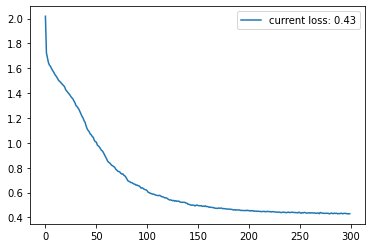

Training complete in 7m 20s


In [ ]:
# Your plot code here
model, losses = train_model(model, criterion, optimizer, scheduler)

In [ ]:
# Text generation with different temperature values here
def generate_text(model, init='JD', length=256, temperature=1.0):

    x_sequence = [token_to_idx[token] for token in init]
    x_sequence = torch.tensor([x_sequence], dtype=torch.int64, device=device)
    hid_state, cell_state = model.initial_state(batch_size=1)
    model.eval()
    
    for i in range(len(init) - 1):
        hid_state, cell_state, _ = model(x_sequence[:, i], hid_state, cell_state)
    
    for _ in range(length - len(init)):
        hid_state, cell_state, logp_next = model(x_sequence[:, -1], hid_state, cell_state)
        p_next = F.softmax(logp_next / temperature, dim=-1).data.cpu().numpy()[0]
        
        next_ix = np.random.choice(len(token_to_idx), p=p_next)
        next_ix = torch.tensor([[next_ix]], dtype=torch.int64, device=device)
        x_sequence = torch.cat([x_sequence, next_ix], dim=1)
        
    return ''.join([tokens[ix] for ix in x_sequence.data.cpu().numpy()[0]])

In [ ]:
print("Generated texts:")

for temp in [0.3, 0.5, 0.6, 1.0, 2.0]:
    gen_txt = generate_text(model, init=sequences[4][:60], length=80, temperature=temp)
    print(gen_txt[61:])
    print("-"*20)
print(sequences[0][61:])

Generated texts:
IJIJJIIHGLGHIIIIIHH
--------------------
IJIJJIIHGLGHIIIIIHH
--------------------
JIJJIIJGHHHGEEDDDDE
--------------------
IJIJIJJGHHGLGIIIIIH
--------------------
JIDJIJJHJILLIIIIJIL
--------------------
DDDCCCCDDGGIIDBBCCD


In [ ]:
generate_text(model, init=sequences[4][:60], length=80, temperature=0.5)[61:]

'IJIJJIIHGLGHIIIIIHI'

2.7 - среднее время замеров

229 - количество id пользователей

все с аномалиями

264 среднее число точек